In [1]:
import numpy as np
import os, re
import json
import h5py as h5
import tensorflow as tf
tf.config.set_visible_devices([], 'GPU')
from tensorflow import keras
from tensorflow.keras import layers, Input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import time
import matplotlib.pyplot as plt

import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

## Load data

Load some data from the [CaloGAN dataset](https://data.mendeley.com/datasets/pvn3xc3wy5/1). Here we use the pion dataset since the skin depth is high and not all the energy is deposited in the calorimeter layers, and hence the conditional probability distribution is more interesting.

In [2]:
def DataLoader(file_name,nevts):
    '''
    Inputs:
    - name of the file to load
    - number of events to use
    Outputs:
    - Generated particle energy (value to condition the flow) (nevts,1)
    - Energy deposition in each layer (nevts,3)
    - Normalized energy deposition per voxel (nevts,504)
    '''
    with h5.File(file_name,"r") as h5f:
        e = h5f['energy'][:int(nevts)].astype(np.float32)
        layer0= h5f['layer_0'][:int(nevts)].astype(np.float32)
        layer1= h5f['layer_1'][:int(nevts)].astype(np.float32)
        layer2= h5f['layer_2'][:int(nevts)].astype(np.float32)

    def preprocessing(data):
        ''' 
        Inputs: Energy depositions in a layer
        Outputs: Total energy of the layer and normalized energy deposition
        '''
        x = data.shape[1]
        y = data.shape[2]
        data_flat = np.reshape(data,[-1,x*y])
        #uncomment below to add noise like caloflows does
        #data_flat +=np.random.uniform(0,1e-3,size=data_flat.shape)
        energy_layer = np.sum(data_flat,-1).reshape(-1,1)
        #Some particle showers have no energy deposition at the last layer
        data_flat = np.ma.divide(data_flat,energy_layer).filled(0)
        return energy_layer,data_flat


    flat_energy , flat_shower = preprocessing(np.nan_to_num(layer0))    
    for il, layer in enumerate([layer1,layer2]):
        energy ,shower = preprocessing(np.nan_to_num(layer))
        flat_energy = np.concatenate((flat_energy,energy),-1)
        flat_shower = np.concatenate((flat_shower,shower),-1)
        
    return e,flat_energy,flat_shower


NSAMPLES = 100000 # number of data points to load

file_path = '/global/home/users/haoxing_du/ToyFlow/gamma.hdf5'
photon_energy, photon_energy_layer, photon_energy_voxel = DataLoader(file_path, NSAMPLES)
print(photon_energy.shape, photon_energy_layer.shape, photon_energy_voxel.shape)

(100000, 1) (100000, 3) (100000, 504)


In [3]:
photon_layer0 = np.array([x[0] for x in photon_energy_layer])
photon_layer1 = np.array([x[1] for x in photon_energy_layer])
photon_layer2 = np.array([x[2] for x in photon_energy_layer])

In [4]:
# Let's look at a random data point
i = np.random.randint(1000)

print(f"True particle energy: {photon_energy[i][0]*1000} MeV")
print(f"Layer 0 energy: {photon_layer0[i]} MeV")
print(f"Layer 1 energy: {photon_layer1[i]} MeV")
print(f"Layer 2 energy: {photon_layer2[i]} MeV")
print(f"Difference (true - total): {photon_energy[i][0]*1000-photon_layer0[i]-photon_layer1[i]-photon_layer2[i]} MeV")

True particle energy: 4448.215484619141 MeV
Layer 0 energy: 1054.229736328125 MeV
Layer 1 energy: 3372.569091796875 MeV
Layer 2 energy: 9.344001770019531 MeV
Difference (true - total): 12.072654724121094 MeV


In [5]:
photon_all_energies = np.concatenate([photon_energy_layer, photon_energy*1000],-1)
photon_all_energies += 1e-10 # in case there are 0s and taking log of 0 is an issue
photon_energies_log = np.log10(photon_all_energies/10000)
photon_energies_log

array([[-0.24220282,  0.7948264 , -1.4598349 ,  0.8383541 ],
       [-0.03841547,  0.32464832, -2.6241615 ,  0.48409063],
       [ 0.00986106,  0.87370723, -2.0131292 ,  0.93243724],
       ...,
       [-1.1419636 ,  0.81691957, -1.4397224 ,  0.8269135 ],
       [ 0.02953856,  0.63603175, -2.339805  ,  0.7382284 ],
       [-0.3300631 , -0.12203376, -2.970138  ,  0.09038221]],
      dtype=float32)

In [33]:
np.std(photon_energies_log[:,2])

1.8321328

In [6]:
class MLP_ODE(keras.Model):
    """Multi-layer NN ode_fn."""
    def __init__(self, num_hidden, num_layers, num_output,num_cond=2,name='mlp_ode'):
        super(MLP_ODE, self).__init__()
        self._num_hidden = num_hidden
        self._num_output = num_output
        self._num_layers = num_layers
        self._num_cond = num_cond
        self._modules = []
        
        #Fully connected layers with tanh activation and linear output
        self._modules.append(Input(shape=(1+self._num_output+self._num_cond))) #time is part of the inputs
        for _ in range(self._num_layers - 1):
            self._modules.append(layers.Dense(self._num_hidden,activation='tanh'))
            
        self._modules.append(layers.Dense(self._num_output,activation=None))
        self._model = keras.Sequential(self._modules)

        if self._num_cond > 1:
            #In more dimensiona, is useful to feed the conditional distributions after passing through an independent network model
            self._cond_model = keras.Sequential(
                [
                    Input(shape=(self._num_cond)),
                    layers.Dense(self._num_hidden,activation='relu'),
                    layers.Dense(self._num_cond,activation=None),
                ])
        
    @tf.function
    def call(self, t, data,conditional_input=None):
        if self._num_cond==1:
            #No network for a single feature
            cond_transform=tf.cast(conditional_input,dtype=tf.float32)
        else:
            cond_transform = self._cond_model(conditional_input)
            
        t = t*tf.ones([data.shape[0],1])
        inputs = tf.concat([t, data,cond_transform], -1)
        return self._model(inputs)

def make_bijector_kwargs(bijector, name_to_kwargs):
    #Hack to pass the conditional information through all the bijector layers
    if hasattr(bijector, 'bijectors'):
        return {b.name: make_bijector_kwargs(b, name_to_kwargs) for b in bijector.bijectors}
    else:
        for name_regex, kwargs in name_to_kwargs.items():
            if re.match(name_regex, bijector.name):
                return kwargs
    return {}

def save_model(model,name="ffjord",checkpoint_dir = '../checkpoints'):
    if not os.path.exists(checkpoint_dir):
        os.makedirs(checkpoint_dir)
    model.save_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf'))

def load_model(model,name="ffjord",checkpoint_dir = '../checkpoints'):
    model.load_weights('{}/{}'.format(checkpoint_dir,name,save_format='tf')).expect_partial()
    
        
class FFJORD(keras.Model):
    def __init__(self, stacked_mlps, batch_size,num_output,trace_type='hutchinson',name='FFJORD'):
        super(FFJORD, self).__init__()
        self._num_output=num_output
        self._batch_size = batch_size 
        ode_solve_fn = tfp.math.ode.DormandPrince(atol=1e-5).solve
        #Gaussian noise to trace solver
        if trace_type=='hutchinson':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_hutchinson
        elif trace_type == 'exact':
            trace_augmentation_fn = tfb.ffjord.trace_jacobian_exact
        else:
            raise Exception("Invalid trace estimator")
        
        
        bijectors = []
        for imlp,mlp in enumerate(stacked_mlps):
            ffjord = tfb.FFJORD(
                state_time_derivative_fn=mlp,
                ode_solve_fn=ode_solve_fn,
                trace_augmentation_fn=trace_augmentation_fn,
                name='bijector{}'.format(imlp) #Bijectors need to be names to receive conditional inputs
            )
            bijectors.append(ffjord)

        #Reverse the bijector order
        self.chain = tfb.Chain(list(reversed(bijectors)))

        self.loss_tracker = keras.metrics.Mean(name="loss")
        #Determien the base distribution
        self.base_distribution = tfp.distributions.MultivariateNormalDiag(
            loc=self._num_output*[0.0], scale_diag=self._num_output*[1.0]
        )
        
        self.flow=self.Transform()
        self._variables = self.flow.variables
        
    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]
    
    @tf.function
    def call(self, inputs, conditional_input=None):
        kwargs = make_bijector_kwargs(self.flow.bijector,{'bijector.': {'conditional_input':conditional_input }})
        return self.flow.bijector.forward(inputs,**kwargs)
        
            
    def Transform(self):        
        return tfd.TransformedDistribution(distribution=self.base_distribution, bijector=self.chain)

    
    @tf.function
    def log_loss(self,_x,_c):
        loss = -tf.reduce_mean(self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        ))
        
        return loss
    
    @tf.function
    def conditional_prob(self,_x,_c):
        prob = self.flow.prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
        
        return prob
    
    @tf.function
    def conditional_log_prob(self,_x,_c):
        return self.flow.log_prob(
            _x,
            bijector_kwargs=make_bijector_kwargs(
                self.flow.bijector, {'bijector.': {'conditional_input': _c}})                                      
        )
    
    
    @tf.function()
    def train_step(self, values):
        #Full shape needs to be given when using tf.dataset
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))

        with tf.GradientTape() as tape:
            loss = self.log_loss(data,cond)
            
        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}
    
    @tf.function
    def test_step(self, values):
        data = values[:self._batch_size,:self._num_output]
        cond = values[:self._batch_size,self._num_output:]
        data.set_shape((self._batch_size,self._num_output))
        cond.set_shape((self._batch_size,cond.shape[1]))
        
        loss = self.log_loss(data,cond)
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=1024)]) #in MB

In [10]:
my_devices = tf.config.experimental.list_physical_devices(device_type='CPU')
tf.config.experimental.set_visible_devices(devices= my_devices, device_type='CPU')

In [9]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [ ]:
LR = 4e-5
NUM_EPOCHS = 100
STACKED_FFJORDS = 5 #Number of stacked transformations
NUM_LAYERS = 3 #Hiddden layers per bijector
NUM_OUTPUT = 3 #Output dimension
NUM_HIDDEN = 10*NUM_OUTPUT #Hidden layer node size
NUM_COND = 1 #Number of conditional dimensions

BATCH_SIZE = 200

#Stack of bijectors 
stacked_mlps = []
for _ in range(STACKED_FFJORDS):
    mlp_model = MLP_ODE(NUM_HIDDEN, NUM_LAYERS, NUM_OUTPUT, NUM_COND)
    stacked_mlps.append(mlp_model)

callbacks=[
        EarlyStopping(monitor='val_loss',patience=10,restore_best_weights=True),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=2, min_lr=1e-6, verbose=1, cooldown=0)
]
    
#Create the model
photon_model = FFJORD(stacked_mlps,BATCH_SIZE,NUM_OUTPUT,trace_type='hutchinson')
photon_model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR))
#model.compile(optimizer=keras.optimizers.SGD(learning_rate=LR))

trainableParams = np.sum([np.prod(v.get_shape()) for v in photon_model.trainable_weights])
nonTrainableParams = np.sum([np.prod(v.get_shape()) for v in photon_model.non_trainable_weights])
totalParams = trainableParams + nonTrainableParams
print(f"Number of trainable params: {trainableParams}")
print(f"Number of nontrainable params: {nonTrainableParams}")
print(f"Number of total params: {totalParams}")

photon_history = photon_model.fit(
    photon_energies_log,
    batch_size=BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=1,
    validation_split=0.1,
    callbacks=callbacks,
)

2022-06-01 16:26:18.994042: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-06-01 16:26:19.285094: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


Number of trainable params: 6015
Number of nontrainable params: 2.0
Number of total params: 6017.0
Epoch 1/100
Instructions for updating:
back_prop=False is deprecated. Consider using tf.stop_gradient instead.
Instead of:
results = tf.while_loop(c, b, vars, back_prop=False)
Use:
results = tf.nest.map_structure(tf.stop_gradient, tf.while_loop(c, b, vars))
450/450 [==============================] - 131s 155ms/step - loss: 5.2521 - val_loss: 3.1332 - lr: 4.0000e-05
Epoch 2/100
450/450 [==============================] - 70s 156ms/step - loss: 1.7043 - val_loss: 0.4573 - lr: 4.0000e-05
Epoch 3/100
450/450 [==============================] - 92s 204ms/step - loss: -0.4426 - val_loss: -0.8631 - lr: 4.0000e-05
Epoch 4/100
450/450 [==============================] - 102s 226ms/step - loss: -1.3325 - val_loss: -1.4397 - lr: 4.0000e-05
Epoch 5/100
450/450 [==============================] - 106s 236ms/step - loss: -1.8478 - val_loss: -1.9658 - lr: 4.0000e-05
Epoch 6/100
450/450 [====================

In [12]:
photon_history.history

{'loss': [5.252067565917969,
  1.7042938470840454,
  -0.4426038861274719,
  -1.332517385482788,
  -1.8477500677108765,
  -2.20111346244812,
  -2.516613006591797,
  -2.741076707839966,
  -2.9459753036499023,
  -3.151848077774048,
  -3.2664794921875,
  -3.355591297149658,
  -3.458893299102783,
  -3.5644257068634033,
  -3.6184775829315186,
  -3.7148597240448,
  -3.731105089187622,
  -3.8141050338745117,
  -3.83449649810791,
  -3.87484073638916,
  -3.96696400642395,
  -3.9467899799346924,
  -3.959630250930786,
  -3.9493677616119385,
  -4.00502347946167,
  -3.990129232406616,
  -4.017844200134277,
  -4.011845588684082,
  -4.030359745025635,
  -4.104716777801514,
  -4.054635047912598,
  -4.083028793334961,
  -4.105833530426025,
  -4.075392723083496,
  -4.080638885498047,
  -4.079764366149902,
  -4.1087846755981445,
  -4.102029323577881,
  -4.070876121520996,
  -4.076999187469482],
 'val_loss': [3.1331701278686523,
  0.45729339122772217,
  -0.8631367683410645,
  -1.4396682977676392,
  -1.9658

In [13]:
min(photon_history.history['val_loss'])

-4.1235456466674805

In [22]:
def plot_hist_3_layers(layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled):
    fig = plt.figure(figsize=(18, 4))
    plt.subplot(131)    
    plt.hist(layer0, bins=np.linspace(0,25000,21), label='actual')
    plt.hist(layer0_sampled, bins=np.linspace(0,25000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
    plt.xlabel('layer 0 energy (MeV)')
    plt.legend()
    plt.subplot(132)    
    plt.hist(layer1, bins=np.linspace(0,90000,21), label='actual')
    plt.hist(layer1_sampled, bins=np.linspace(0,90000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
    plt.xlabel('layer 1 energy (MeV)')
    plt.legend()
    plt.subplot(133)    
    plt.hist(layer2, bins=np.linspace(0,29000,21), label='actual')
    plt.hist(layer2_sampled, bins=np.linspace(0,29000,21), fc=(0,0,0,0), edgecolor='orange', linewidth=1.2, label='learned')
    plt.xlabel('layer 2 energy (MeV)')
    plt.legend()
    
def plot_scat_layers_v_tot(energy, layer0, layer1, layer2, \
                           layer0_sampled, layer1_sampled, layer2_sampled, \
                           max0, max1, max2):
    fig = plt.figure(figsize=(16, 8))
    plt.subplot(231)
    plt.scatter(energy, layer0, label='actual')
    plt.legend()
    plt.subplot(232)
    plt.scatter(energy, layer1, label='actual')
    plt.subplot(233)
    plt.scatter(energy, layer2, label='actual')
    plt.subplot(234)
    plt.scatter(energy, layer0_sampled, color='orange', label='learned')
    plt.ylim(0,max0)
    plt.legend()
    plt.subplot(235)
    plt.scatter(energy, layer1_sampled, color='orange', label='learned')
    plt.ylim(0,max1)
    plt.subplot(236)
    plt.scatter(energy, layer2_sampled, color='orange', label='learned')
    plt.ylim(0,max2)
    fig.supxlabel('total energy (GeV)')
    fig.supylabel('energy in each layer (MeV)')

def plot_sum_v_tot(energy, layer0, layer1, layer2, layer0_sampled, layer1_sampled, layer2_sampled):
    fig = plt.figure(figsize=(12, 5))
    plt.subplot(121)
    plt.scatter(energy*1000, layer0+layer1+layer2, label='actual')
    plt.legend()
    plt.subplot(122)
    plt.scatter(energy*1000, layer0_sampled + layer1_sampled + layer2_sampled, color='orange', label='learned')
    plt.ylim(0,100000)
    plt.legend()
    fig.supxlabel('total energy (MeV)')
    fig.supylabel('energy in all layers (MeV)')

def plot_avg_v_tot(avg0_true, avg1_true, avg2_true, avg0_sampled, avg1_sampled, avg2_sampled):
    fig = plt.figure(figsize=(16, 4))
    plt.subplot(131)
    plt.plot(np.linspace(5,100,20), avg0_true, label='actual')
    plt.plot(np.linspace(5,100,20), avg0_sampled, c='orange', label='learned')
    plt.legend()
    plt.subplot(132)
    plt.plot(np.linspace(5,100,20), avg1_true)
    plt.plot(np.linspace(5,100,20), avg1_sampled, c='orange')
    plt.subplot(133)
    plt.plot(np.linspace(5,100,20), avg2_true)
    plt.plot(np.linspace(5,100,20), avg2_sampled, c='orange')
    fig.supxlabel('total energy (GeV)')
    fig.supylabel('average energy in each layer (GeV)')
    
def scanner(model, point, N, min_range, max_range):
    points = np.array([point] * (N+1))
    zs = np.array([i/N for i in range(N+1)]).reshape((N+1,1))
    zs = zs * (max_range - min_range) + min_range
    log_probs = model.conditional_log_prob(points, zs)
    #max_prob = np.amax(log_probs)
    max_index = np.argmax(log_probs)
    c_max = max_index / N
    return c_max

In [15]:
NSAMPLES = 100000

photon_energy_scaled = photon_energies_log[:,-1].reshape((NSAMPLES,1))

#Sample the learned distribution
photon_samples_with_energy = photon_model.flow.sample(
    NSAMPLES,
    bijector_kwargs=make_bijector_kwargs(
        photon_model.flow.bijector, {'bijector.': {'conditional_input': photon_energy_scaled}})
)

photon_samples_scaled = np.concatenate([photon_samples_with_energy, photon_energy_scaled],-1)
photon_samples_expd = 10**photon_samples_scaled * 10000
photon_layer0_sampled = photon_samples_expd[:,0]
photon_layer1_sampled = photon_samples_expd[:,1]
photon_layer2_sampled = photon_samples_expd[:,2]

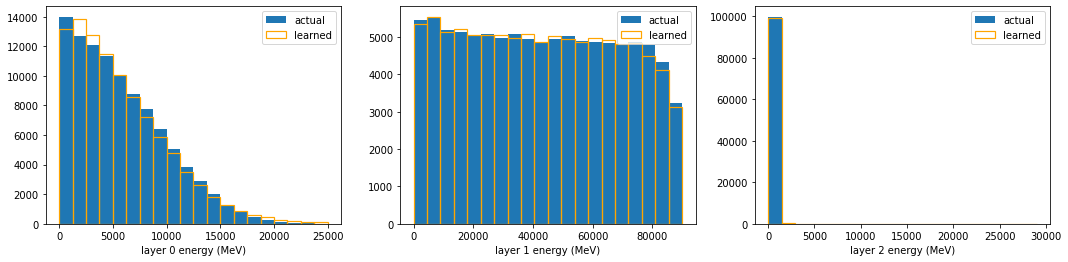

In [16]:
plot_hist_3_layers(photon_layer0, photon_layer1, photon_layer2, \
                   photon_layer0_sampled, photon_layer1_sampled, photon_layer2_sampled)

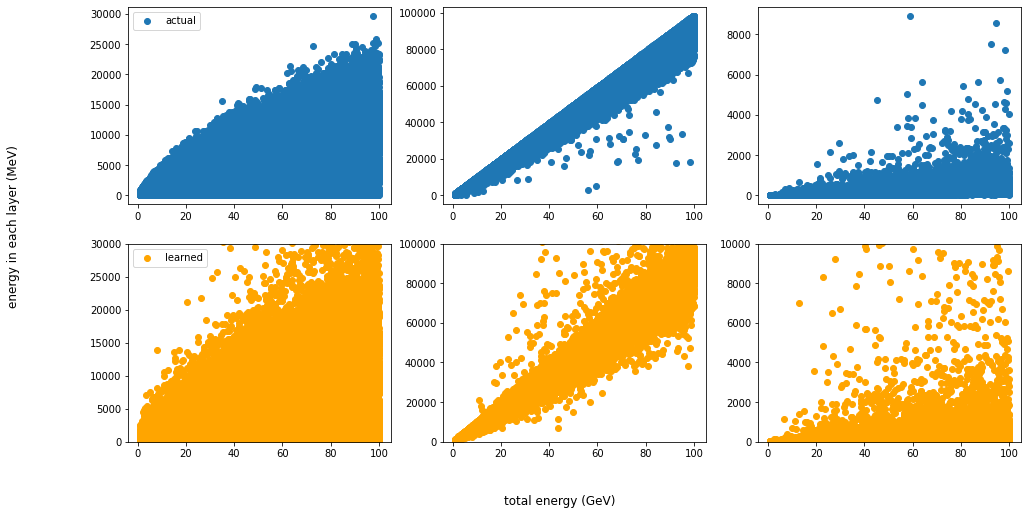

In [17]:
plot_scat_layers_v_tot(photon_energy, photon_layer0, photon_layer1, photon_layer2, \
                       photon_layer0_sampled, photon_layer1_sampled, photon_layer2_sampled, \
                       30000, 100000, 10000)

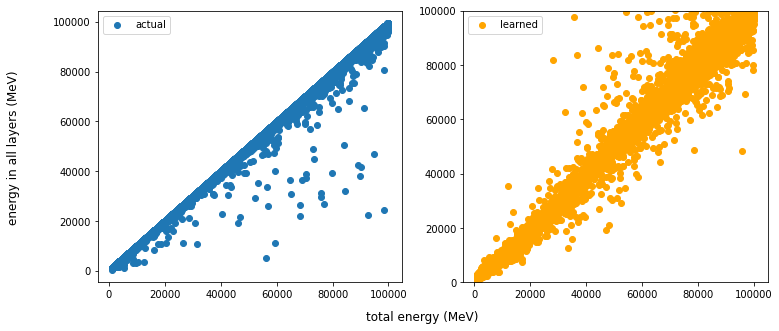

In [23]:
plot_sum_v_tot(photon_energy, photon_layer0, photon_layer1, photon_layer2, \
                       photon_layer0_sampled, photon_layer1_sampled, photon_layer2_sampled)

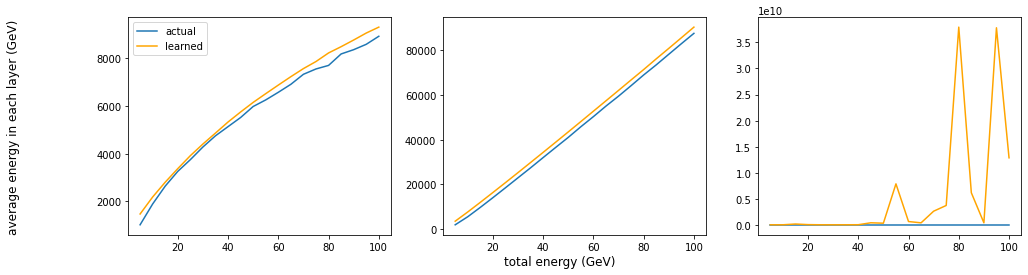

In [19]:
N_SAMPLES = 100000
energy_range = range(5, 105, 5)
photon_avg_layer_energies = []

for e in energy_range:
    #print(energy)
    conditionals = np.full((N_SAMPLES,1), e)
    conditionals = np.log10(conditionals/10)
    photon_samples = photon_model.flow.sample(
        NSAMPLES,
        bijector_kwargs=make_bijector_kwargs(
            photon_model.flow.bijector, {'bijector.': {'conditional_input': conditionals}})
    )
    photon_samples_scaled_back = 10**photon_samples * 10000
    avg0 = np.mean(photon_samples_scaled_back[:,0])
    avg1 = np.mean(photon_samples_scaled_back[:,1])
    avg2 = np.mean(photon_samples_scaled_back[:,2])
    photon_avg_layer_energies.append([avg0, avg1, avg2])

photon_avg_energies = np.array(photon_avg_layer_energies)
photon_avg0_sampled = photon_avg_energies[:,0]
photon_avg1_sampled = photon_avg_energies[:,1]
photon_avg2_sampled = photon_avg_energies[:,2]

photon_all_energies = np.concatenate([photon_energy_layer, photon_energy], -1)
photon_avg_layer_energies_true = []

for e in energy_range:
    selected_rows = photon_all_energies[(photon_all_energies[:,3] >= e-5) & (photon_all_energies[:,3] <=e)]
    avg0 = np.mean(selected_rows[:,0])
    avg1 = np.mean(selected_rows[:,1])
    avg2 = np.mean(selected_rows[:,2])
    photon_avg_layer_energies_true.append([avg0, avg1, avg2])

photon_avg_energies_true = np.array(photon_avg_layer_energies_true)
photon_avg0_true = photon_avg_energies_true[:,0]
photon_avg1_true = photon_avg_energies_true[:,1]
photon_avg2_true = photon_avg_energies_true[:,2]

plot_avg_v_tot(photon_avg0_true, photon_avg1_true, photon_avg2_true, \
               photon_avg0_sampled, photon_avg1_sampled, photon_avg2_sampled)

In [20]:
i = np.random.randint(100000)
e0, e1, e2 = photon_layer0[i], photon_layer1[i], photon_layer2[i]
en = np.array([e0, e1, e2]).astype(np.float32)
en += 1e-10
en = np.log10(en/10000)

c_max = scanner(photon_model, en, 50, -1, 1)
ans = 10 ** c_max * 10000

print(f"True particle energy: {photon_energy[i][0]*1000} MeV")
print(f"Layer 0 energy: {photon_layer0[i]} MeV")
print(f"Layer 1 energy: {photon_layer1[i]} MeV")
print(f"Layer 2 energy: {photon_layer2[i]} MeV")
print("Inferred total energy (MeV): ", ans)

True particle energy: 2250.441074371338 MeV
Layer 0 energy: 311.6619567871094 MeV
Layer 1 energy: 1912.767578125 MeV
Layer 2 energy: 1.065905213356018 MeV
Inferred total energy (MeV):  15848.931924611135


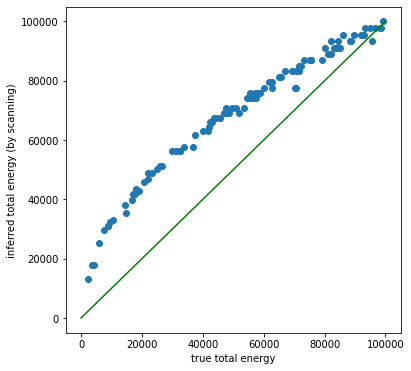

In [25]:
photon_true_ens = []
photon_inferred_ens = []
for j in range(100):
    i = np.random.randint(100000)
    e0, e1, e2 = photon_layer0[i], photon_layer1[i], photon_layer2[i]
    en = np.array([e0, e1, e2]).astype(np.float32)
    en += 1e-10
    en = np.log10(en/10000)
    c_max = scanner(photon_model, en, 100, -1, 1)
    ans = 10 ** c_max * 10000
    photon_true_ens.append(photon_energy[i][0]*1000)
    photon_inferred_ens.append(ans)

fig = plt.figure(figsize=(6,6))
plt.scatter(photon_true_ens, photon_inferred_ens)
plt.xlabel("true total energy")
plt.ylabel("inferred total energy (by scanning)")
plt.plot([0,50000,100000], [0,50000,100000], c='green')